# 0. Imports

In [1]:
from functools import partial

import matplotlib.pyplot as plt
from jax import jit
import jax.numpy as jnp
import optax

from dynamax.generalized_gaussian_ssm.experimental.optimizer import CMGFOptimizerParams, CMGFOptimizer
from dynamax.generalized_gaussian_ssm.experimental.demos.spiral_classif_demo import *

# 1. MLP Classifier Example

We set up some groundwork.

In [2]:
def evaluate_and_plot(ax, input_grid, params, predict_fn, input, output, title="CMGF-EKF One-Pass Trained MLP Classifier"):
    # Evaluate the trained MLP on grid and plot
    Z_cmgf = posterior_predictive_grid(input_grid, params, predict_fn, binary=False)
    return plot_posterior_predictive(ax, input, output, title, input_grid, Z_cmgf)

In [3]:
# Generate spiral dataset
input, output = generate_spiral_dataset()

# Define grid on input space
input_grid = generate_input_grid(input)

In [4]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [15, 15], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)

# Define model and initial opt_state
state_dim, emission_dim = flat_params.size, output_dim
eps = 1e-4
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), eps, 1-eps) # Clip to prevent divergence
pred_mean_fn = lambda w, x: sigmoid_fn(w, x)
pred_cov_fn = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim)

In [5]:
def fit(opt_state, optimizer, input, output, pred_mean_fn, pred_cov_fn):
    params = opt_state.mean

    @jit
    def step(params, opt_state, x, y):
        updates, opt_state = optimizer.update(x, pred_mean_fn, pred_cov_fn, y, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state
    
    for i, (x, y) in enumerate(zip(input, output)):
        params, opt_state = step(params, opt_state, x, y)
    
    return params

Next, we try some experiments.

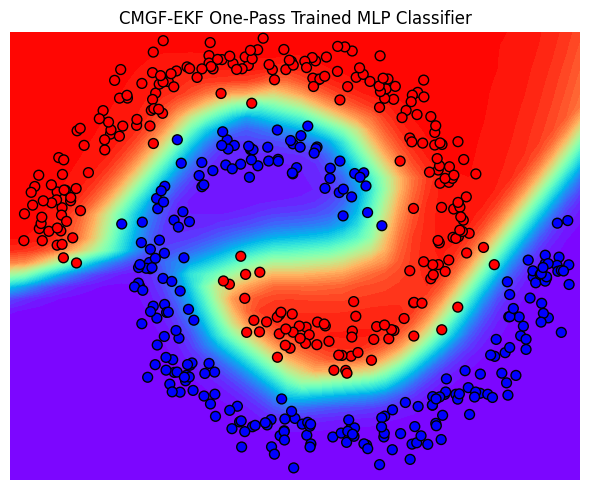

In [6]:
# Initialize cmgf-ekf optimizer
ekf_optimizer = CMGFOptimizer('ekf')
opt_state = CMGFOptimizerParams(mean=initial_mean, cov=initial_covariance)
params = fit(opt_state, ekf_optimizer, input, output, pred_mean_fn, pred_cov_fn)

fig, ax = plt.subplots(figsize=(6, 5))
evaluate_and_plot(ax, input_grid, params, sigmoid_fn, input, output);

Next we simplify the model to decrease the predictive power.

In [7]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [7, 7], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)

# Define model and initial opt_state
state_dim, emission_dim = flat_params.size, output_dim
eps = 1e-4
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), eps, 1-eps) # Clip to prevent divergence
pred_mean_fn = lambda w, x: sigmoid_fn(w, x)
pred_cov_fn = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim)

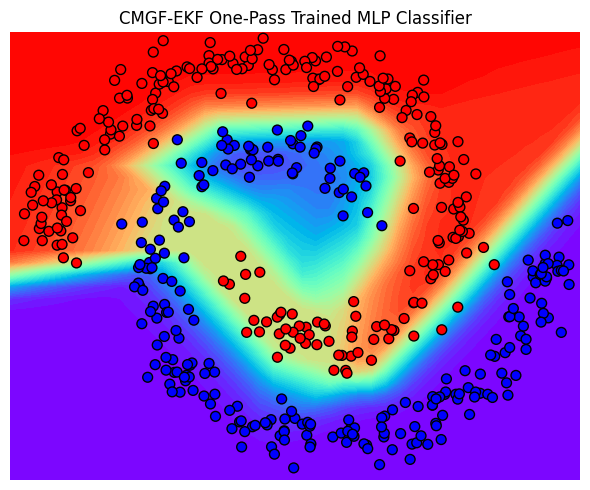

In [8]:
# Initialize cmgf-ekf optimizer
ekf_optimizer = CMGFOptimizer('ekf')
opt_state = CMGFOptimizerParams(mean=initial_mean, cov=initial_covariance)
params = fit(opt_state, ekf_optimizer, input, output, pred_mean_fn, pred_cov_fn)

fig, ax = plt.subplots(figsize=(6, 5))
evaluate_and_plot(ax, input_grid, params, sigmoid_fn, input, output);

Note below that iterated posterior linearization is able to make better predictions despite the limiting simplicity of the model. However, training takes longer.

In [9]:
# Initialize cmgf optimizer
ekf_optimizer = CMGFOptimizer('ekf', 40)
opt_state = CMGFOptimizerParams(mean=initial_mean, cov=initial_covariance)
params = fit(opt_state, ekf_optimizer, input, output, pred_mean_fn, pred_cov_fn)

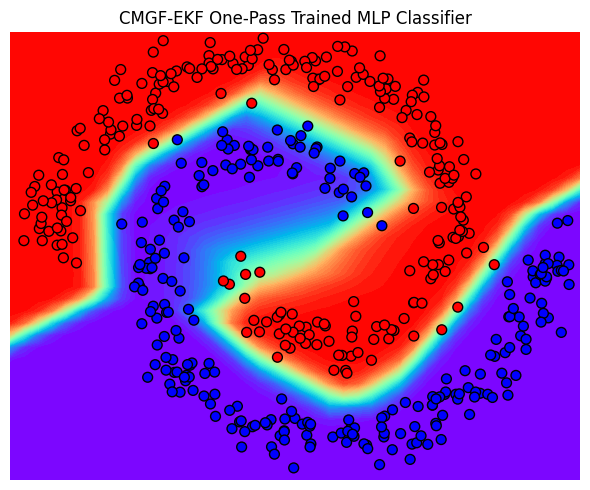

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))
evaluate_and_plot(ax, input_grid, params, sigmoid_fn, input, output);

# 3. Comparison with SGD

For comparison, we move back to the more complex MLP architecture.

In [11]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [15, 15], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)

# Define model and initial opt_state
state_dim, emission_dim = flat_params.size, output_dim
eps = 1e-4
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn(w, x)), eps, 1-eps) # Clip to prevent divergence
pred_mean_fn = lambda w, x: sigmoid_fn(w, x)
pred_cov_fn = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim)

In [12]:
def loss_optax(params, x, y, apply_fn):
    y_hat = apply_fn(params, x)
    loss_value = -(y * jnp.log(y_hat) + (1-y) * jnp.log(1 - y_hat))
    return loss_value.mean()

In [13]:
loss_fn = partial(loss_optax, apply_fn = sigmoid_fn)

In [14]:
def fit_optax(params, optimizer, input, output, loss_fn, num_epochs):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, x, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(zip(input, output)):
            params, opt_state, loss_value = step(params, opt_state, x, y)
    
    return params

In [15]:
sgd_optimizer = optax.sgd(learning_rate=1e-2)

In [16]:
params = fit_optax(flat_params, sgd_optimizer, input, output, loss_fn, num_epochs=1)

Single-pass SGD is no good.

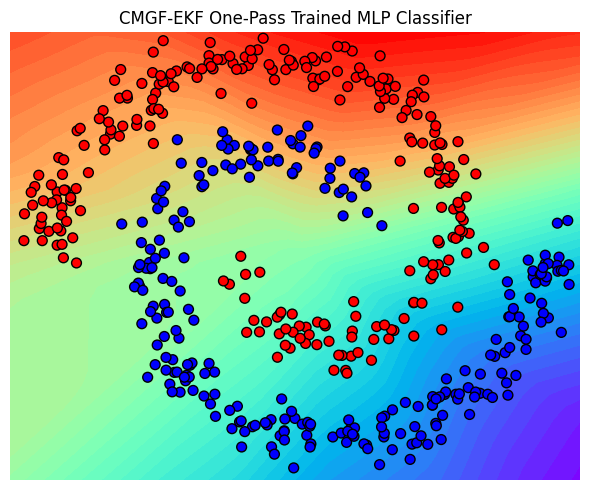

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
evaluate_and_plot(ax, input_grid, params, sigmoid_fn, input, output);

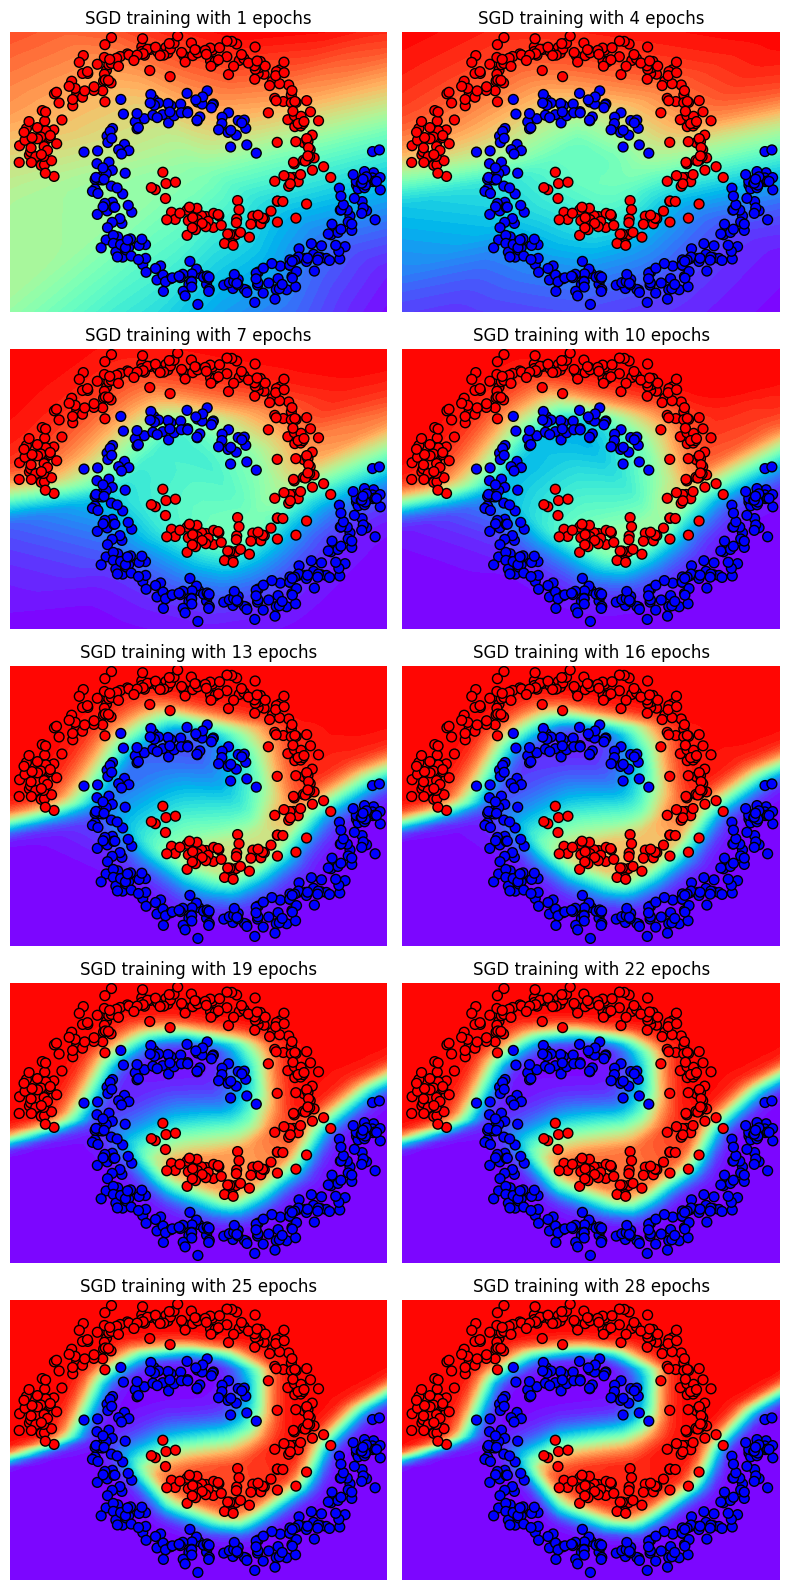

In [18]:
epoch_range = jnp.arange(1, 30, 3)
n = len(epoch_range)
fig, ax = plt.subplots(n // 2, 2, figsize=(8, 16))
for step, axi in zip(epoch_range, ax.flatten()):
    params = fit_optax(flat_params, sgd_optimizer, input, output, loss_fn, num_epochs=step)
    title = f'SGD training with {step} epochs'
    evaluate_and_plot(axi, input_grid, params, sigmoid_fn, input, output, title=title)